<a href="https://colab.research.google.com/github/Anuththara99/Anuththara99/blob/master/TeleDerm_ClassificationMobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import pandas to load our dataset
import pandas as pd

In [4]:
# to check which GPU has been allocated 
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
#to check tensorflow version
import tensorflow as tf
tf.__version__

'2.11.0'

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization,ReLU,DepthwiseConv2D,AvgPool2D,GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn import metrics

# Importing Dataset

In [7]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/FYP_DATASET/TeleDerm/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/FYP_DATASET/TeleDerm/Test/")

## Count Dataset

In [8]:
#Count dataset 
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

8360
2382


In [9]:
# Define parameters for the loader
batch_size = 32
img_height = 224
img_width = 224 
size = (224, 224)

## Image Resize

In [ ]:
# image resize

def preprocess_image(image):
    image = tf.image.resize(image, size)
    return image  

    
class_path = pathlib.Path("/content/drive/MyDrive/FYP_DATASET/TeleDerm/Train/Acne/")
# class_path = data_dir_train / "Acne"
for image_path in class_path.glob("*.jpg"):
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_jpeg(image)
    image = preprocess_image(image)
    image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))
    # tf.io.write_file(str(data_dir_train / "resized" / class_folder / image_path.name), image)
    #use this code to replace 
    tf.io.write_file(str(image_path), image)     


# for class_folder in os.listdir(data_dir_train):
#     class_path = data_dir_train / class_folder
#     for image_path in class_path.glob("*.jpg"):
#         image = tf.io.read_file(str(image_path))
#         image = tf.image.decode_jpeg(image)
#         image = preprocess_image(image)
#         image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))
#         # tf.io.write_file(str(data_dir_train / "resized" / class_folder / image_path.name), image)
#         #use this code to replace 
#         tf.io.write_file(str(image_path), image) 

# for class_folder in os.listdir(data_dir_test):
#     class_path = data_dir_test / class_folder
#     for image_path in class_path.glob("*.jpg"):
#         image = tf.io.read_file(str(image_path))
#         image = tf.image.decode_jpeg(image)
#         image = preprocess_image(image)
#         image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))
#         # tf.io.write_file(str(data_dir_test / "resized" / class_folder / image_path.name), image)
#         #use this code to replace
#         tf.io.write_file(str(image_path), image)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-09224b915c0d>", line 12, in <module>
    image = tf.image.decode_jpeg(image)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_image_ops.py", line 1170, in decode_jpeg
    return decode_jpeg_eager_fallback(
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_image_ops.py", line 1244, in decode_jpeg_eager_fallback
    _result = _execute.execute(b"DecodeJpeg", 1, inputs=_inputs_flat,
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown imag

InvalidArgumentError: ignored

# Load using keras.preprocessing
load these images off disk using the image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')
valid_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='validation')

Found 8360 files belonging to 7 classes.
Using 6688 files for training.
Found 8360 files belonging to 7 classes.
Using 1672 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['Acne', 'Chickenpox', 'Eczema', 'Monkeypox', 'Psoriasis', 'Ringworm', 'Rosacea']


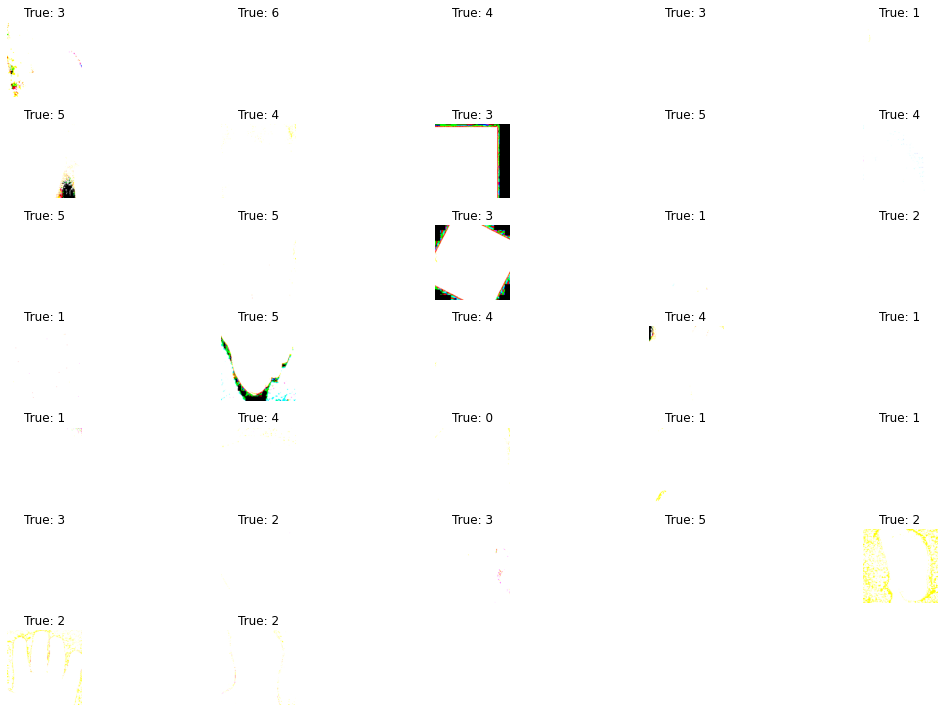

In [12]:
#visualize data
import matplotlib.pyplot as plt

# Plotting function
def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(7, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if predictions is not None:
            title = f'True: {label}\nPred: {predictions[i]}'
        else:
            title = f'True: {label}'
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Plotting a batch of training data
batch = next(iter(train_ds))
images, labels = batch
plot_images(images, labels)

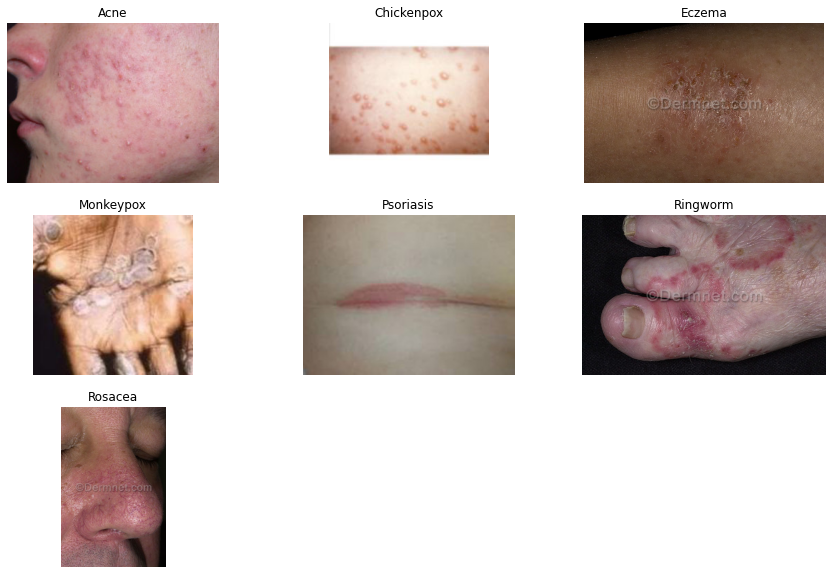

In [13]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    # file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))
    if file_path:
      img = PIL.Image.open(file_path[0])
    # img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [14]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


Check the configuration of gpu and use gpu.

In [15]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


# data augmentation

In [16]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

# Dataset.prefetch() overlaps data preprocessing and model execution while training.

## Compile the model

In [ ]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        print(label)      
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        # plt.title(class_names[label[i]])
        plt.axis("off")

tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


tf.Tensor([5 1 1 3 0 3 5 1 6 3 5 3 5 3 0 2 6 2 2 4 1 0 2 5 4 2 2 4 5 5 5 4], shape=(32,), dtype=int32)


# Feature Extraction 

In [20]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
#creating Data Loaders for 
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(data_dir_train,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(data_dir_test,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 7749 images belonging to 7 classes.
Testing images:
Found 2104 images belonging to 7 classes.


In [21]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [23]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [24]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [25]:
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')
valid_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='validation')

Found 7749 files belonging to 7 classes.
Using 6200 files for training.
Found 7749 files belonging to 7 classes.
Using 1549 files for validation.


In [26]:
# Create model
num_classes = len(train_ds.class_names)  
# resnet_model = create_model(resnet_url, num_classes=class_names)
resnet_model = create_model(resnet_url, num_classes=num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=14,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230313-125218
Epoch 1/10
243/243 [==============================] - 951s 4s/step - loss: 1.1295 - accuracy: 0.5757 - val_loss: 1.0377 - val_accuracy: 0.6426
Epoch 2/10
243/243 [==============================] - 80s 331ms/step - loss: 0.7638 - accuracy: 0.7154 - val_loss: 1.0507 - val_accuracy: 0.6469
Epoch 3/10
243/243 [==============================] - 81s 334ms/step - loss: 0.6559 - accuracy: 0.7573 - val_loss: 1.0357 - val_accuracy: 0.6654
Epoch 4/10
243/243 [==============================] - 82s 339ms/step - loss: 0.5976 - accuracy: 0.7778 - val_loss: 1.0187 - val_accuracy: 0.6811
Epoch 5/10
243/243 [==============================] - 82s 339ms/step - loss: 0.5386 - accuracy: 0.8028 - val_loss: 1.0784 - val_accuracy: 0.6844
Epoch 6/10
243/243 [==============================] - 83s 341ms/step - loss: 0.4966 - accuracy: 0.8206 - val_loss: 0.9730 - val_accuracy: 0.7115
Epoch 7/10
243/243 [==============================] - 83s

In [28]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

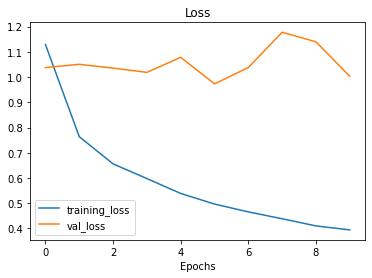

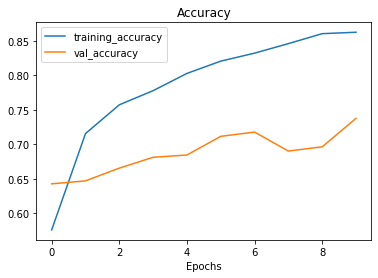

In [29]:
plot_loss_curves(resnet_history)

In [30]:
# Resnet summary 
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 23,579,143
Trainable params: 14,343
Non-trainable params: 23,564,800
_________________________________________________________________


# Classification 

## Create the model, compile and train the model

In [31]:
def depth_block(x, strides):
    x = DepthwiseConv2D(3,strides=strides,padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def single_conv_block(x,filters):
    x = Conv2D(filters, 1,use_bias=False)(x)
    x= BatchNormalization()(x)
    x = ReLU()(x)
    return x
def combo_layer(x,filters,strides):
    x = depth_block(x,strides)
    x = single_conv_block(x, filters)
    return x
def MobileNet(input_shape=(224,224,3),n_classes = 9,inbuilt_aug=True):
    if inbuilt_aug:
        model = data_augmentation
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)))
    x = Conv2D(32,3,strides=(2,2),padding = 'same', use_bias=False) (model.output)
    x =  BatchNormalization()(x)
    x = ReLU()(x)
    x = combo_layer(x,64, strides=(1,1))
    x = combo_layer(x,128,strides=(2,2))
    x = combo_layer(x,128,strides=(1,1))
    x = combo_layer(x,256,strides=(2,2))
    x = combo_layer(x,256,strides=(1,1))
    x = combo_layer(x,512,strides=(2,2))
    for _ in range(5):
        x = combo_layer(x,512,strides=(1,1))
    x = combo_layer(x,1024,strides=(2,2))
    x = combo_layer(x,1024,strides=(1,1))
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(128)(x)
    output = Dense(n_classes,activation='softmax')(x)
    model = Model(model.input, output)
    return model

In [32]:
model = MobileNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     288   

In [33]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Training the model

In [34]:
epochs = 14

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/7
194/194 [==============================] - 51s 181ms/step - loss: 1.8770 - accuracy: 0.2890 - val_loss: 2.0713 - val_accuracy: 0.2176
Epoch 2/7
194/194 [==============================] - 32s 163ms/step - loss: 1.5989 - accuracy: 0.3650 - val_loss: 2.2857 - val_accuracy: 0.1607
Epoch 3/7
194/194 [==============================] - 82s 422ms/step - loss: 1.4676 - accuracy: 0.4229 - val_loss: 2.1896 - val_accuracy: 0.1607
Epoch 4/7
194/194 [==============================] - 34s 170ms/step - loss: 1.3892 - accuracy: 0.4548 - val_loss: 1.4743 - val_accuracy: 0.4312
Epoch 5/7
194/194 [==============================] - 33s 164ms/step - loss: 1.2935 - accuracy: 0.4908 - val_loss: 1.6109 - val_accuracy: 0.4164
Epoch 6/7
194/194 [==============================] - 34s 172ms/step - loss: 1.2581 - accuracy: 0.5032 - val_loss: 1.7534 - val_accuracy: 0.3764
Epoch 7/7
194/194 [==============================] - 33s 164ms/step - loss: 1.2264 - accuracy: 0.5282 - val_loss: 1.8502 - val_accuracy:

# Visualizing the results

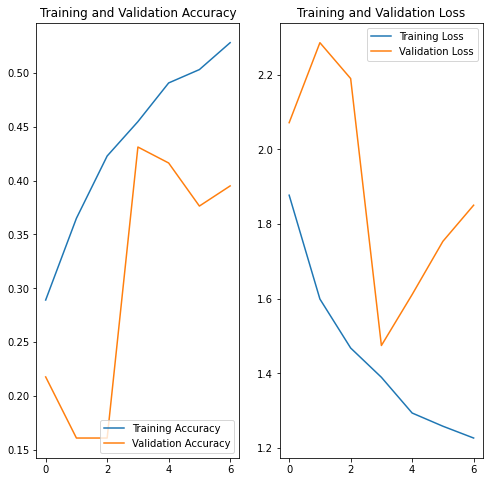

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'Acne': 145,
 'Chickenpox': 316,
 'Eczema': 407,
 'Monkeypox': 895,
 'Psoriasis': 324,
 'Ringworm': 155,
 'Rosacea': 125}

In [13]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Acne,741
Chickenpox,487
Eczema,1624
Monkeypox,858
Psoriasis,1141
Ringworm,1290
Rosacea,695


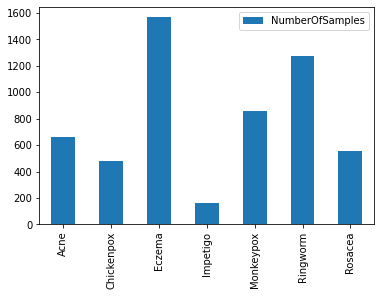

In [ ]:
class_df.plot.bar()
plt.show()

# Model evaluation

In [ ]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=118)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1777 files belonging to 7 classes.


In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [ ]:
actual = tf.keras.utils.to_categorical(
    label_batch, num_classes=9, dtype='int32'
)

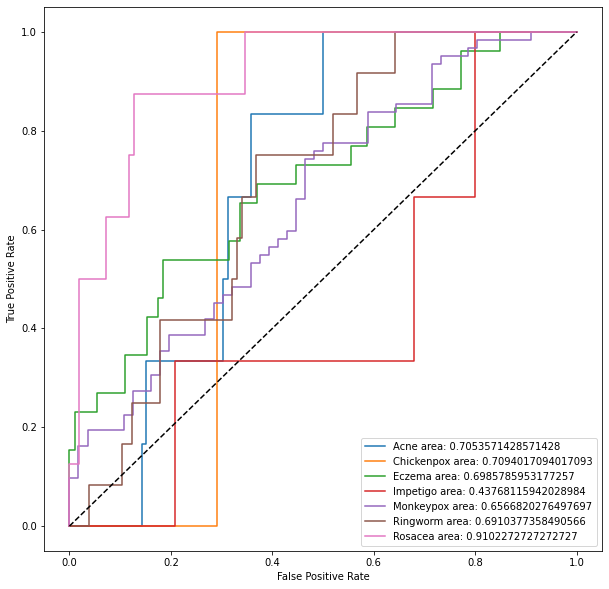

In [ ]:
fpr0, tpr0, _ = metrics.roc_curve(actual[:,0],  predictions[:,0])
fpr1, tpr1, _ = metrics.roc_curve(actual[:,1],  predictions[:,1])
fpr2, tpr2, _ = metrics.roc_curve(actual[:,2],  predictions[:,2])
fpr3, tpr3, _ = metrics.roc_curve(actual[:,3],  predictions[:,3])
fpr4, tpr4, _ = metrics.roc_curve(actual[:,4],  predictions[:,4])
fpr5, tpr5, _ = metrics.roc_curve(actual[:,5],  predictions[:,5])
fpr6, tpr6, _ = metrics.roc_curve(actual[:,6],  predictions[:,6])

auc0 = metrics.roc_auc_score(actual[:,0],  predictions[:,0])
auc1 = metrics.roc_auc_score(actual[:,1],  predictions[:,1])
auc2 = metrics.roc_auc_score(actual[:,2],  predictions[:,2])
auc3 = metrics.roc_auc_score(actual[:,3],  predictions[:,3])
auc4 = metrics.roc_auc_score(actual[:,4],  predictions[:,4])
auc5 = metrics.roc_auc_score(actual[:,5],  predictions[:,5])
auc6 = metrics.roc_auc_score(actual[:,6],  predictions[:,6])


fpr100 = tpr100 = np.array(range( 0,11))/10

plt.figure(figsize=(10,10))
plt.plot(fpr0,tpr0, label = "Acne area: " + str(auc0))
plt.plot(fpr1,tpr1, label = "Chickenpox area: " + str(auc1))
plt.plot(fpr2,tpr2, label = "Eczema area: " + str(auc2))
plt.plot(fpr3,tpr3, label = "Impetigo area: " + str(auc3))
plt.plot(fpr4,tpr4, label = "Monkeypox area: " + str(auc4))
plt.plot(fpr5,tpr5, label = "Ringworm area: " + str(auc5))
plt.plot(fpr6,tpr6, label = "Rosacea area: " + str(auc6))


plt.plot(fpr100,tpr100,'--',color = "black")
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ddd.jpg", bbox_inches = "tight")
plt.show()

In [ ]:
test_score=model.evaluate(test_dataset)

16/16 [==============================] - 5s 193ms/step - loss: 2.3833 - accuracy: 0.2088


## Prediction 

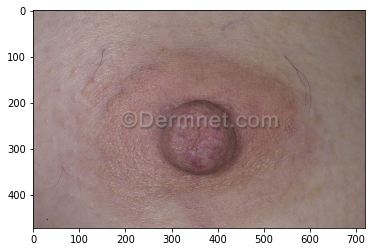

In [ ]:
img_path = '/content/drive/MyDrive/FYP_DATASET/TeleDerm/Train/Acne/062.jpg'
plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
# from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

# Load the image
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
x = image.img_to_array(img)

# Reshape the array to match the expected input shape of your model
x = np.expand_dims(x, axis=0)

# Normalize the pixel values
x = x / 255.0

# Use the model to predict the class probabilities
preds = model.predict(x)

# Print the predicted class probabilities
print(preds)

1/1 [==============================] - 1s 657ms/step
[[1.8972823e-01 9.4634600e-02 3.8607404e-02 2.5507557e-04 2.8176537e-02
  6.3738626e-01 1.1129132e-02 1.6889164e-05 6.5856162e-05]]
